# Persian to English translation

### this is a joint affair of Armin Behjati and Bahram Mohammadpour

In this notebook we try to make a sequence-to-sequence model . we are going to make a Persian to English translation model . we will be using TEP ,English-Persian corpus which is extracted from movie subtitles and is sentence aligned . it has 4 milion tokens on each side . Total number of bilingual sentences is 612086 .Average sentence length is 7.8 words. 

We are using fastai library to make things faster and easier . 
Also thanks to Hiromi Suenaga for explanations and notes .

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from fastai.text import *

/home/bahram/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
import html

In [5]:
PATH = Path('data')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname='TEP'
en_fname = PATH/f'{fname}.en'
fa_fname = PATH/f'{fname}.fa'

We need pairs of sentences on for english and one for persian(farsi) . now we have 612086 sentence pairs .

In [7]:
lines = ((en,fa)for en, fa in zip(open(en_fname, encoding='utf-8'),
                                  open(fa_fname, encoding='utf-8')))
sen = [(e,f) for e,f in lines if e and f]

In [8]:
sen[:5] , len(sen)

([('raspy breathing .\n', '\ufeffصداي خر خر .\n'),
  ('dad .\n', 'پدر .\n'),
  ('maybe its the wind .\n', 'شايد صداي باد باشه .\n'),
  ('no .\n', 'نه .\n'),
  ('stop please stop .\n', 'دست نگه داريد خواهش ميکنم دست نگه داريد .\n')],
 612086)

we are just going to save them for further use .

In [9]:
pickle.dump(sen, (PATH/'fa-en.pkl').open('wb'))

we can easily split them aprt into English and Persian sentences lists .

In [10]:
en,fa = zip(*sen)


Here we tokenize the sentences . again we are using the spacy tokenizer and due to the lack of good persian tokenizer available we decided to try english tokenizer for persian too and it worked fine ! 
proc_all_mp is processing every sentence across multiple processes .

In [11]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en))

In [12]:
fa_tok = Tokenizer.proc_all_mp(partition_by_cores(fa))

Here is example of a sentence after tokenization .

In [13]:
en_tok[5], fa_tok[5]

(['you',
  'have',
  'a',
  'week',
  ',',
  'evans',
  'then',
  'well',
  'burn',
  'the',
  'house',
  '.',
  '\n'],
 ['اوانز',
  'تو',
  'فقط',
  'يک',
  'هفته',
  'وقت',
  'داري',
  'وگرنه',
  'خونتو',
  'خواهيم',
  'سوزوند',
  '.',
  '\n'])

Now we have to save the tokens .

In [14]:
keep = np.array([len(o)<30 for o in en_tok])

In [15]:
en_tok = np.array(en_tok)[keep]
fa_tok = np.array(fa_tok)[keep]

In [16]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fa_tok, (PATH/'fa_tok.pkl').open('wb'))

Here are the top 25 most frequent words .

In [17]:
freq = Counter(p for o in fa_tok for p in o)
freq.most_common(25)

[('\n', 612051),
 ('.', 474293),
 ('،', 103134),
 ('من', 90505),
 ('به', 76135),
 ('را', 66759),
 ('تو', 60411),
 ('و', 60239),
 ('که', 59504),
 ('از', 55806),
 ('اين', 47409),
 ('اون', 44937),
 ('يک', 33618),
 ('در', 32070),
 ('با', 29032),
 ('ما', 28843),
 ('رو', 26067),
 ('كه', 24502),
 ('شما', 21629),
 ('هم', 19892),
 ('بايد', 18554),
 ('براي', 18230),
 ('نه', 18117),
 ('مي', 16622),
 ('بود', 16085)]

We are going to limit the number of words to 50000 to keep things simple . We insert a few extra tokens for beginning of stream (_bos_), padding (_pad_), end of stream (_eos_), and unknown (_unk).
we will return 3 for the tokens we haven't seen . 

In [18]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(50000)]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

Now we have a list of IDs for both Persian and English and functions to turn them to words and reverse . 

In [19]:
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')
fa_ids,fr_itos,fa_stoi = toks2ids(fa_tok,'fa')

In [20]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [21]:
en_ids,en_itos,en_stoi = load_ids('en')
fa_ids,fa_itos,fa_stoi = load_ids('fa')

In [22]:
[fa_itos[o] for o in fa_ids[1]], len(en_itos), len(fa_itos)

(['پدر', '.', '\n', '_eos_'], 50004, 50004)

# Word Vectors 

We are going to use pre-trained word vectors here but I think that transfer learning and fine-tuning pre-trained models would work better which is something wee are going to experiment more on it !
 Here we use fasttext word vectors which has the dimension of 300 .

In [23]:
import fastText as ft


In [24]:
en_vecs = ft.load_model(str((PATH/'wiki.en.bin')))

In [25]:
fa_vecs = ft.load_model(str((PATH/'wiki.fa.bin')))

We are going to convert them into standard python dictionary for each word .

In [26]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

In [27]:
en_vecd = get_vecs('en', en_vecs)
fa_vecd = get_vecs('fa', fa_vecs)

In [28]:
en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
fa_vecd = pickle.load(open(PATH/'wiki.fa.pkl','rb'))

In [29]:
dim_en_vec = len(en_vecd[','])
dim_fa_vec = len(fa_vecd[','])
dim_en_vec,dim_fa_vec

(300, 300)

In [30]:
en_vecs = np.stack(list(en_vecd.values()))
en_vecs.mean(),en_vecs.std()

(0.0075652334, 0.29283327)

# ModelData

We are going to grab a maximum length for sentences .

In [31]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
falen_90 = int(np.percentile([len(o) for o in fa_ids], 97))
enlen_90,falen_90

(21, 18)

In [32]:
en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
fa_ids_tr = np.array([o[:falen_90] for o in fa_ids])

Here we define our dataset which requiers two things : len and an indexer .

In [33]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

Making training and validation set using a list of random numbers .

In [34]:
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1
en_trn,fa_trn = en_ids_tr[trn_keep],fa_ids_tr[trn_keep]
en_val,fa_val = en_ids_tr[~trn_keep],fa_ids_tr[~trn_keep]
len(en_trn),len(en_val)

(550799, 61252)

Now we create our Datasets .

In [35]:
trn_ds = Seq2SeqDataset(fa_trn,en_trn)
val_ds = Seq2SeqDataset(fa_val,en_val)

We have declare our padding index because it's going to padd all sentences so that they have equal sizes . as before we are going to use the sampler to save some memory by puting together sentences with similar sizes .

In [36]:
bs = 128

In [37]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [38]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [39]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(18, 21), (13, 6), (18, 15), (11, 4), (10, 4)]

The architecture has an encoder that's going to take a sequence of tokens then it returns a final hidden state or just a vector which we feed to the decoder RNN . 

We have to make an embedding with the size of vocabsize by 300(fasttext vectors size ) .
we multiply by 3 because we had the std of about 0.3 and the standard is 1 .

In [40]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w]*3)
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb

Here we set the number of hidden states and number of layers .

In [41]:
nh,nl = 256,2


In [42]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data[0]

In [43]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

We are going to go through and put it through the embedding. We are going to stick it through the RNN, dropout, and a linear layer. We will then append the output to a list which will be stacked into a single tensor and get returned. 
the input to the embedding is the previous word that we translated. 
outp.data.max : It looks in its tensor to find out which word has the highest probability. max in PyTorch returns two things: the first thing is what is that max probability and the second is what is the index into the array of that max probability. So we want that second item which is the word index with the largest thing.
dec_inp : It contains the word index into the vocabulary of the word.
by adding bidirectional=True to our encoder now we have a bidirectional model .
 we also feed in the actual correct word at the early traing so that it has less difficulty to learn. that's what we call pr-force .
We also used Attention here . the way it was used was that we created a little nueral network inside and we trained it end to end .
w2h = self.l2(h[-1])
u = F.tanh(w1e + w2h)
a = F.softmax(u @ self.V, 0)
We are going to take the last layer’s hidden state and we are going to stick it into a linear layer. Then we stick it into a nonlinear activation and then we are going to do a matrix multiply. Now rather than just taking the last encoder output, we have the whole tensor of all of the encoder outputs which we just weight by this neural net we created .
 

In [44]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.25)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh*2, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh*2, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None , ret_attn=False):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

If the generated sequence length is shorter than the sequence length of the target, we need to add some padding. PyTorch padding function requires a tuple of 6 to pad a rank 3 tensor (sequence length, batch size, by number of words in the vocab). Each pair represents padding before and after that dimension.
F.cross_entropy expects a rank 2 tensor, but we have sequence length by batch size, so we just flatten it out. That is what view(-1, ...) does.



In [45]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))

to_gpu will not put to in the GPU if you do not have one.
We could just call Learner to turn that into a learner, but if we call RNN_Learner, it does add in save_encoder and load_encoder that can be handy sometimes .

In [46]:
rnn = Seq2SeqRNN(fa_vecd, fa_itos, dim_fa_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

29332 ['...', 'کني', 'ميخوام', 'ميکني', 'ميدوني']
6363 ["'s", "n't", '...', "'m", "'re"]


as usuall we use the learning rate finder to find the best learning rate .

 66%|██████▌   | 2837/4304 [07:47<04:01,  6.07it/s, loss=19.4]

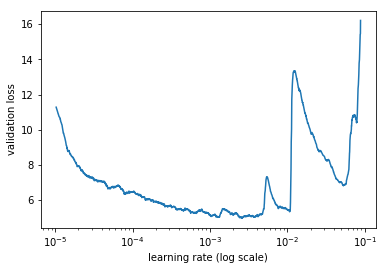

In [47]:
learn.lr_find()
learn.sched.plot()

In [48]:
lr= 1e-3
wd = 0

we train the model .

In [62]:
learn.fit(lr, 1, wds=wd, use_clr=(20,10), cycle_len=15, stepper = Seq2SeqStepper)

epoch      trn_loss   val_loss                                
    0      1.788608   6.152387  
    1      2.027214   4.972059                                
    2      1.997908   4.378297                                
    3      2.163803   4.001754                                
    4      2.255261   3.823183                                
    5      2.33996    3.825839                                
    6      2.470269   3.503114                                
    7      2.553205   3.394398                                
    8      2.667889   3.23554                                 
    9      2.653444   3.195496                                
    10     2.792435   3.154075                                
    11     2.63283    3.183128                                
    12     2.501625   3.198065                                
    13     2.53512    3.153566                                
    14     2.659681   3.171559                                


[array([3.17156])]

In [49]:
import time
learn.save('fa2en')

In [50]:
learn.load('fa2en')

# test

Let's test our translation . 
we can also visualize our attention list and see at each time step where is the attention .

In [52]:
x,y = next(iter(val_dl))
probs,attns = learn.model(V(x),ret_attn=True)
preds = to_np(probs.max(2)[1])

In [53]:
attn = to_np(attns[...,180])

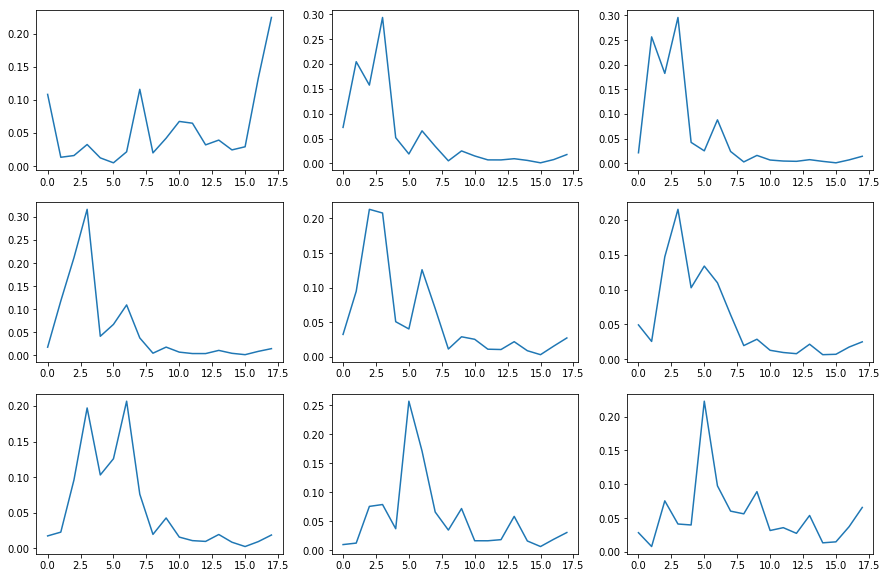

In [54]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

In [55]:
for i in range(170,180):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    

من آخرين آزمايش گذشتت بودم . اگر داري به . اين گوش ميدي ، تو شکست خورده ي
i was your final test of forgiveness . and if you re listening to this , then you ve failed .
i was the last test . if you re listening to this , you you failed . 
 _eos_
نه ، راستش . حالم زياد خوب نيست . 
 _eos_
no , i � m not . you know , i do nt i do nt feel very well . 

no , i m not . i m not so good . 
 _eos_
اون كه پرواز آخره . دوست دارم با من بياي تئاتر . 
 _eos_
it � s the late flight . i really want you to come to the play . please . 
 _eos_
he s the last one . i d like to come in to me . 
 _eos_
، پس با خودم مي‌گفتم اگر تو با من به تئاتر بياي واقعا كمكم ميكني . 
 _eos_
so i was thinking that if you came to the play , i think that would really help . 
 _eos_
so you can help me if you come with me to the theater . 
 _eos_
ميخواستي من را بكشي شريك . الانه كه وضعيت 211 بشه . 
 _eos_
do you want me murder , partner are you crazy , there has been a busy 211 . . 
 _eos_
you re going to kill me . . 
 _eos_
احم